In [189]:
from CFD_2D_TDJ import *
import os
import matplotlib.colors as colors

In [268]:
# u = np.load("/Users/Q556220/Projects/MPS encoding/data_big/u_0.24999999999999414.npy")
# v = np.load("/Users/Q556220/Projects/MPS encoding/data_big/v_0.24999999999999414.npy")
u = np.load("/Users/Q556220/Projects/MPS encoding/data_big/u_0.49999999999997996.npy")
v = np.load("/Users/Q556220/Projects/MPS encoding/data_big/v_0.49999999999997996.npy")
u = u.T
v = v.T

In [269]:
def schmidt_spectrum(A):  
    # converts scalar field to scale-resolved MPS matrices
    Nx, Ny = A.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    A_vec = A.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation B
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    B_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        A_index = get_A_index(w)                # get original index for w
        B_index = int(w, 2)                     # get corresponding index for w
        w = bin(B_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        B_vec[0, B_index] = A_vec[0, A_index]   

    node = B_vec    # set first node of MPS
    S_list = []

    for _ in range(n-1):
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        U, S, V = plain_svd(node, full_matrices=False)
        normalized_S = S / np.sqrt(np.sum(S**2))
        S_list.append(normalized_S)               
        node = np.matmul(np.diag(S), V)
        # node = V

    return S_list

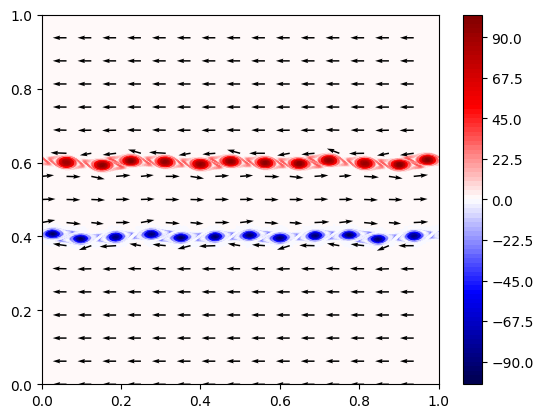

In [270]:
n = 10                          # number of qubits
N = 2**n                        # number of grid points
dx = 1 / (N-1)                  # finite spacing
x = np.linspace(0, 1-dx, N)
y = np.linspace(0, 1-dx, N)
X, Y = np.meshgrid(x, y)
n_s = 2**(n-4)    
plt.figure()
plt.contourf(X, Y, Dx(v, dx).T-Dy(u, dx).T, 100, cmap="seismic")
plt.colorbar()
plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u.T[::n_s, ::n_s], v.T[::n_s, ::n_s], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [271]:
def sv_b(A, i):  
    # converts scalar field to scale-resolved MPS matrices
    Nx, Ny = A.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    A_vec = A.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation B
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    B_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        A_index = get_A_index(w)                # get original index for w
        B_index = int(w, 2)                     # get corresponding index for w
        w = bin(B_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        B_vec[0, B_index] = A_vec[0, A_index]   

    node = B_vec    # set first node of MPS
    S_list = []
    S_ = []
    m, n = node.shape
    node = node.reshape((4**i, -1))
    U, S, V = plain_svd(node, full_matrices=False)
    normalized_S = S / np.sqrt(np.sum(S**2))

    return normalized_S

In [272]:
def calc_acc(schmidt_spectra):
    nec_vals = []
    for spectrum in schmidt_spectra:
        sum_val = 0
        num = 0
        for val in spectrum:
            sum_val += val**2
            num += 1
            if np.sqrt(sum_val) > 0.99:
                break
        nec_vals.append(num)
    
    return nec_vals

In [273]:
u_schmidt = schmidt_spectrum(u)
v_schmidt = schmidt_spectrum(v)

In [274]:
u_acc = calc_acc(u_schmidt)
v_acc = calc_acc(v_schmidt)

In [275]:
u_acc

[2, 3, 3, 2, 1, 1, 1, 1, 1]

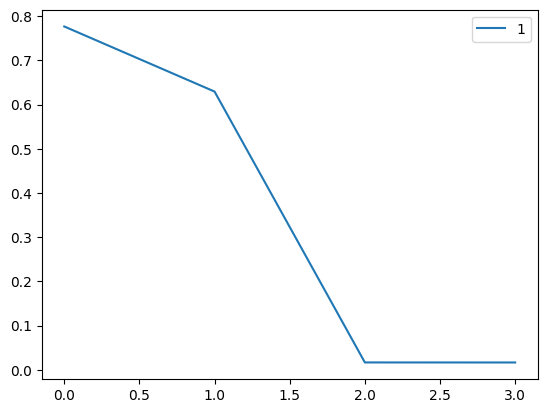

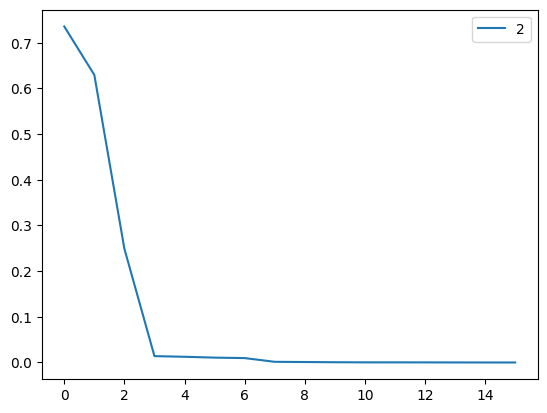

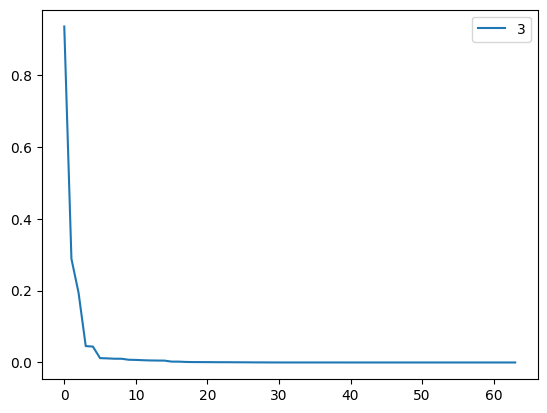

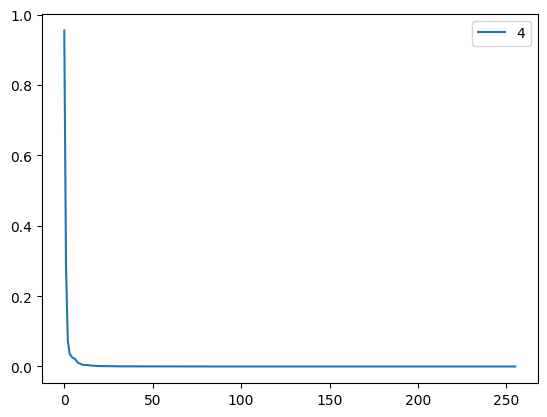

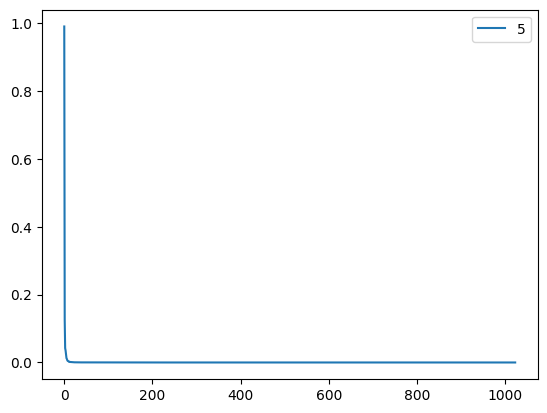

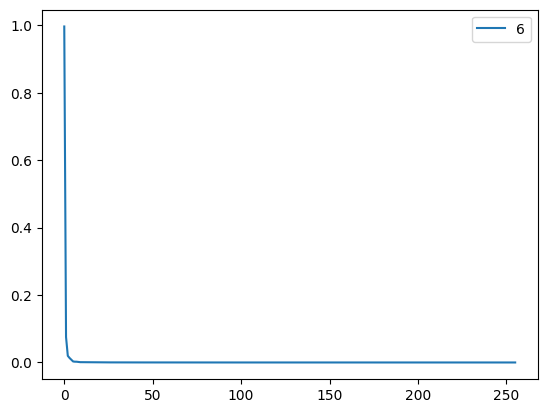

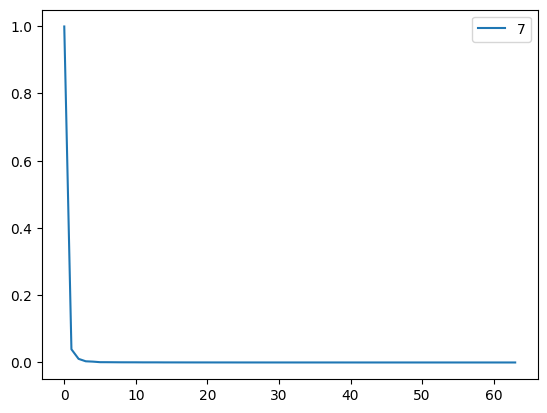

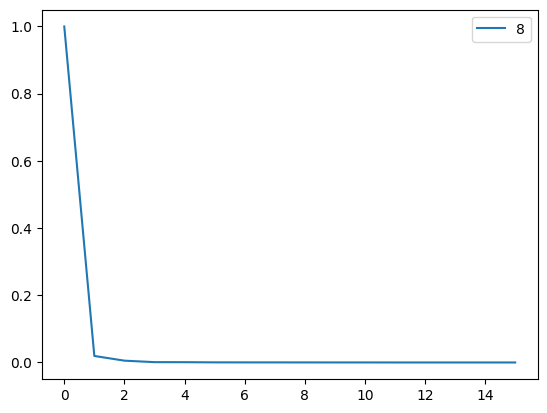

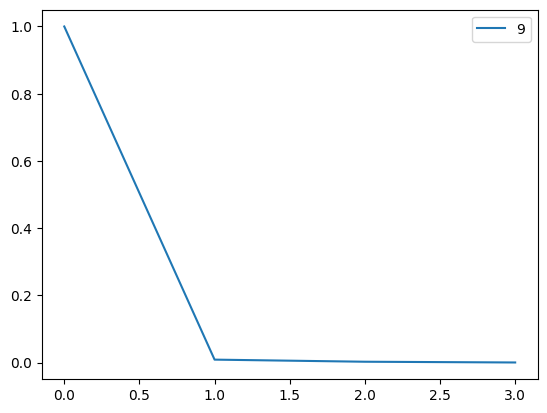

In [276]:
for i in range(len(u_schmidt)):
    plt.plot(u_schmidt[i], label=str(i+1))
    plt.legend()
    plt.show()

In [277]:
n = 4**5
u_schmidt_pad = []
v_schmidt_pad = []
for i in range(len(u_schmidt)):
    temp_1 = np.zeros(n)
    temp_2 = np.zeros(n)
    temp_1[:u_schmidt[i].shape[0]] = u_schmidt[i]
    temp_2[:v_schmidt[i].shape[0]] = v_schmidt[i]
    u_schmidt_pad.append(temp_1)
    v_schmidt_pad.append(temp_2)

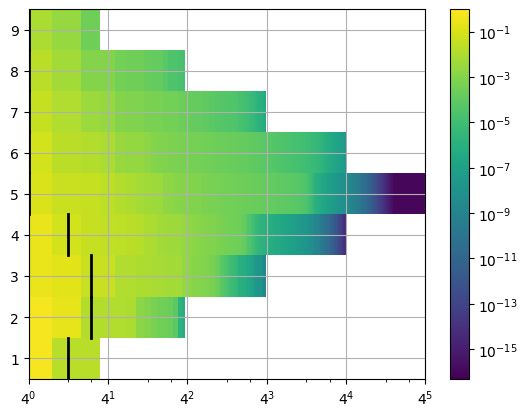

In [278]:
x = np.arange(n)
y = np.arange(1, len(u_schmidt)+1)
X, Y = np.meshgrid(x, y)
Z = u_schmidt_pad

fig, ax = plt.subplots()

pc = ax.pcolormesh(X, Y, Z, cmap='viridis', norm=colors.LogNorm(vmin=5e-17, vmax=1))
ax.set_xscale('log', base=4)
plt.xlim([1, 4**5])
fig.colorbar(pc)
ax.grid()
for i, num in enumerate(u_acc):
    plt.plot([num, num], [i+0.5, i+1.5], 'k-', lw=2)
plt.show()

In [279]:
test_1 = np.ones((3, 4, 3))
test_2 = np.ones((3, 4, 3))
test_3 = np.ones((3, 3, 3))

path = np.einsum_path('abc,cbd,ace->de', test_1, test_2, test_3, optimize='greedy')

In [283]:
path[0]

['einsum_path', (0, 1), (0, 1)]

In [284]:
np.einsum('abc,cbd,ace->de', test_1, test_2, test_3, optimize=path[0])

array([[36., 36., 36.],
       [36., 36., 36.],
       [36., 36., 36.]])